In [17]:
import os
import logging
from pathlib import Path

import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
import sys
from joblib import Parallel, delayed
logging.basicConfig(level=logging.ERROR)


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [18]:
# 
class CFG:
    def __init__(self, mode="train", kaggle_notebook=False, debug=False):
        assert mode in ["train", "inference"], "mode must be 'train' or 'inference'"
        self.mode = mode
        self.KAGGLE_NOTEBOOK = kaggle_notebook
        self.debug = debug

        # ===== Path Settings =====
        if self.KAGGLE_NOTEBOOK:
            self.OUTPUT_DIR = ''
            self.train_datadir = '/kaggle/input/birdclef-2025/train_audio'
            self.train_csv = '/kaggle/input/birdclef-2025/train.csv'
            self.test_soundscapes = '/kaggle/input/birdclef-2025/test_soundscapes'
            self.submission_csv = '/kaggle/input/birdclef-2025/sample_submission.csv'
            self.taxonomy_csv = '/kaggle/input/birdclef-2025/taxonomy.csv'
            self.spectrogram_npy = '/kaggle/input/birdclef25-mel-spectrograms/birdclef2025_melspec_5sec_256_256.npy'
            
            # kaggle notebookならここを変更
            self.model_path = "/kaggle/input/birdclef-2025-baseline-fold0-0404"
            
            self.device = "cpu"
            self.batch_size = 8
            self.n_jobs = 3
            
        else:
            self.OUTPUT_DIR = '../data/result/'
            self.train_datadir = '../data/raw/train_audio/'
            self.train_csv = '../data/raw/train.csv'
            self.test_soundscapes = '../data/raw/test_soundscapes/'
            self.submission_csv = '../data/raw/sample_submission.csv'
            self.taxonomy_csv = '../data/raw/taxonomy.csv'
            self.spectrogram_npy = '../data/processed/mel-spec_0329/birdclef2025_melspec_5sec_256_256.npy'
            self.MODELS_DIR = "../models/"
            
            # ローカルならここを変更
            self.model_path =  "../models/sfzn1_hd_hl512_psd_srsnxt_3_vino////"
            
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
            self.batch_size = 32
            self.n_jobs = 3

        # ===== Model Settings =====
        self.model_name = 'efficientnet_b0'
        self.pretrained = True if mode == "train" else False
        self.in_channels = 1

        # ===== Audio Settings =====
        self.FS = 32000
        self.WINDOW_SIZE = 5
        self.TARGET_DURATION = 5
        self.TARGET_SHAPE = (256, 256)
        self.N_FFT = 1024
        self.HOP_LENGTH = 512
        self.N_MELS = 148
        self.FMIN = 20
        self.FMAX = 16000
        
        self.seed = 42
        
        # smoothingの係数
        self.smooth_center_weight = 0.6
        self.smooth_neighbor_weight = 0.2
        
        # ===== Inference Mode =====
        if mode == "inference":
            self.use_tta = False
            self.tta_count = 3
            self.threshold = 0.5

            self.use_specific_folds = False
            self.folds = [0, 1, 2, 3, 4]  # Used only if use_specific_folds is True

            self.debug_count = 3
            self.ensemble_strategy = "mean" # "mean", "max", "min", "median" など
            
            
            
    def update_debug_settings(self):
        if self.debug:
            self.epochs = 2
            self.selected_folds = [0]

In [19]:
cfg = CFG(mode='inference', kaggle_notebook=False)

if cfg.KAGGLE_NOTEBOOK:
    !pip install -U openvino-telemetry  --no-index --find-links /kaggle/input/pip-hub
    !pip install -U openvino  --no-index --find-links /kaggle/input/pip-hub
    sys.path.append("/kaggle/input/birdclef-2025-libs/")
    
from openvino.runtime import Core
from module import models_lib, utils_lib, preprocess_lib, inference_lib

# Set seed
utils_lib.set_seed(cfg.seed)

In [20]:
print(f"Using device: {cfg.device}")
print(f"Loading taxonomy data...")
taxonomy_df = pd.read_csv(cfg.taxonomy_csv)
species_ids = taxonomy_df['primary_label'].tolist()
num_classes = len(species_ids)
print(f"Number of classes: {num_classes}")

Using device: cuda
Loading taxonomy data...
Number of classes: 206


In [21]:
# mel変換
def process_audio_file(audio_path, cfg):
    """1ファイル分のmelspecデータを返す（row_id, melspecのリスト）"""
    dataset = []
    soundscape_id = Path(audio_path).stem
    try:
        audio_data, _ = librosa.load(audio_path, sr=cfg.FS)
        total_segments = int(len(audio_data) / (cfg.FS * cfg.WINDOW_SIZE))

        for segment_idx in range(total_segments):
            start = int(segment_idx * cfg.FS * cfg.WINDOW_SIZE)
            end = int(start + cfg.FS * cfg.WINDOW_SIZE)
            segment_audio = audio_data[start:end]

            mel_spec = preprocess_lib.process_audio_segment(segment_audio, cfg)
            row_id = f"{soundscape_id}_{(segment_idx + 1) * cfg.WINDOW_SIZE}"

            dataset.append({
                "row_id": row_id,
                "mel_spec": mel_spec
            })
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
    return dataset


# 並列化してmelspecを生成
def generate_melspec_dataset(cfg):
    test_dir = Path(cfg.test_soundscapes)
    if not test_dir.exists():
        print(f"Test directory {test_dir} does not exist.")
        return []

    test_files = list(test_dir.glob('*.ogg'))
    if len(test_files) == 0:
        print("No test audio files found.")
        return []

    if cfg.debug:
        print(f"Debug mode enabled, using only {cfg.debug_count} files")
        test_files = test_files[:cfg.debug_count]

    results = Parallel(n_jobs=cfg.n_jobs)(
        delayed(process_audio_file)(path, cfg) for path in tqdm(test_files, desc="Parallel melspec gen")
    )
    dataset = [item for sublist in results for item in sublist]
    return dataset

In [22]:

# openvinoモデルの読み込み
def load_openvino_models(vino_dir, cfg):
    models = []
    vino_dir = Path(vino_dir)

    if cfg.use_specific_folds:
        fold_ids = cfg.folds
        xml_files = [vino_dir / f"model_fold{f}.xml" for f in fold_ids]
    else:
        xml_files = sorted(vino_dir.glob("model_fold*.xml"))

    for xml_path in xml_files:
        bin_path = xml_path.with_suffix(".bin")

        if not xml_path.exists() or not bin_path.exists():
            print(f"⚠️ Warning: Missing files for {xml_path.stem}")
            continue

        core = Core()
        model_ir = core.read_model(xml_path)
        compiled_model = core.compile_model(model_ir, device_name="CPU")
        models.append(compiled_model)

        # 🔍 モデルのファイル名（fold情報）をログに出す
        print(f"✅ Loaded model: {xml_path.name}")

    print(f"🎉 Total {len(models)} OpenVINO model(s) loaded from {vino_dir}")
    return models

# openvinoモデルによる推論
def run_inference_openvino(dataset, models_ir, cfg, species_ids):
    row_ids = []
    all_preds = []

    for i in range(0, len(dataset), cfg.batch_size):
        batch = dataset[i:i+cfg.batch_size]

        mel_list = [item["mel_spec"] for item in batch]
        input_tensor = np.stack(mel_list).astype(np.float32)  # (B, H, W)
        input_tensor = np.expand_dims(input_tensor, axis=1)  # (B, 1, H, W)

        preds_per_model = []
        for model in models_ir:
            input_layer = model.input(0)
            output_layer = model.output(0)
            result = model([input_tensor])[output_layer]
            probs = 1 / (1 + np.exp(-result))  # sigmoid
            preds_per_model.append(probs)

        # アンサンブル戦略の選択
        if cfg.ensemble_strategy == "mean":
            avg_preds = np.mean(preds_per_model, axis=0)
        elif cfg.ensemble_strategy == "max":
            avg_preds = np.max(preds_per_model, axis=0)
        elif cfg.ensemble_strategy == "min":
            avg_preds = np.min(preds_per_model, axis=0)
        elif cfg.ensemble_strategy == "median":
            avg_preds = np.median(preds_per_model, axis=0)
        else:
            raise ValueError(f"Unknown ensemble strategy: {cfg.ensemble_strategy}")

        all_preds.append(avg_preds)
        row_ids.extend([item["row_id"] for item in batch])

    predictions = np.concatenate(all_preds, axis=0)
    return row_ids, predictions

In [23]:
def smooth_submission_df(submission_df, cfg, weights=None):
    """
    Smooth predictions using weighted moving average over a 5-frame window: [-2, -1, 0, +1, +2],
    then blend with per-class global average within each soundscape segment group.

    Parameters:
        submission_df: pd.DataFrame with 'row_id' and prediction columns.
        cfg: config object (interface compatibility).
        weights: List of 5 floats (default = [0.1, 0.2, 0.4, 0.2, 0.1]).

    Returns:
        pd.DataFrame with smoothed predictions.
    """
    print("Smoothing submission predictions with global average blend...")

    if weights is None:
        weights = np.array([0.1, 0.2, 0.4, 0.2, 0.1])
    else:
        weights = np.array(weights)

    sub = submission_df.copy()
    cols = sub.columns[1:]
    groups = sub['row_id'].astype(str).str.rsplit('_', n=1).str[0].values
    unique_groups = np.unique(groups)

    for group in unique_groups:
        idx = np.where(groups == group)[0]
        preds = sub.iloc[idx][cols].values  # (T, C)
        T, C = preds.shape

        # エッジ処理：端を繰り返すようにパディング
        padded = np.pad(preds, ((2, 2), (0, 0)), mode='edge')  # (T+4, C)

        # 平滑化：5点加重平均（[-2, -1, 0, +1, +2]）
        smoothed = (
            padded[0:T]   * weights[0] +
            padded[1:T+1] * weights[1] +
            padded[2:T+2] * weights[2] +
            padded[3:T+3] * weights[3] +
            padded[4:T+4] * weights[4]
        )

        # 各クラスの平均予測を20%混ぜる（全セグメントに対して一様に加える）
        classwise_mean = smoothed.mean(axis=0, keepdims=True)  # shape: (1, C)
        smoothed = smoothed * 0.8 + classwise_mean * 0.2

        sub.iloc[idx, 1:] = smoothed

    return sub

In [24]:
print("Generating dataset...")
dataset = generate_melspec_dataset(cfg)

print("Loading OpenVINO models...")
vino_dir = Path(cfg.model_path).with_name(Path(cfg.model_path).name)
models_ir = load_openvino_models(vino_dir, cfg)

if not models_ir:
    raise RuntimeError("No OpenVINO models found.")

print("Running OpenVINO inference...")
if len(dataset) > 0:
    row_ids, predictions = run_inference_openvino(dataset, models_ir, cfg, species_ids)
else:
    print("No test data available, generating empty submission.")
    row_ids = []
    predictions = []

# smoothing前の予測値を保存
submission_df = utils_lib.create_submission(row_ids, predictions, species_ids, cfg)
submission_path = os.path.join(cfg.OUTPUT_DIR, 'submission_before_smoothing.csv')
submission_df.to_csv(submission_path, index=False)

print(f"Submission saved to {submission_path}")


Generating dataset...


Parallel melspec gen:   0%|          | 0/71 [00:00<?, ?it/s]

Loading OpenVINO models...
✅ Loaded model: model_fold0.xml
✅ Loaded model: model_fold3.xml
✅ Loaded model: model_fold4.xml
🎉 Total 3 OpenVINO model(s) loaded from ../models/sfzn1_hd_hl512_psd_srsnxt_3_vino
Running OpenVINO inference...
Creating submission dataframe...
Submission saved to ../data/result/submission_before_smoothing.csv


In [25]:
# smoothingして再度保存．
smoothed_df = smooth_submission_df(submission_df, cfg)
smoothed_submission_path = os.path.join(cfg.OUTPUT_DIR, 'submission.csv')
smoothed_df.to_csv(smoothed_submission_path, index=False)
print(f"Smoothed submission saved to {smoothed_submission_path}")

Smoothing submission predictions with global average blend...
Smoothed submission saved to ../data/result/submission.csv


In [26]:
# 提出用ファイルを読み込む
submission = pd.read_csv(os.path.join(cfg.OUTPUT_DIR, 'submission.csv'))
submission.head(12)

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H02_20230420_074000_5,0.000042,0.000036,0.000012,0.000031,0.000149,0.000079,0.001540,0.000093,0.000424,...,0.000064,0.000028,0.000230,0.000050,0.000001,0.000053,0.000019,0.000651,0.000039,0.000035
1,H02_20230420_074000_10,0.000045,0.000036,0.000013,0.000034,0.000144,0.000075,0.001246,0.000087,0.000380,...,0.000073,0.000030,0.000204,0.000064,0.000002,0.000061,0.000025,0.000646,0.000052,0.000044
2,H02_20230420_074000_15,0.000046,0.000036,0.000015,0.000039,0.000124,0.000069,0.000968,0.000080,0.000358,...,0.000096,0.000036,0.000219,0.000089,0.000002,0.000078,0.000034,0.000666,0.000071,0.000054
3,H02_20230420_074000_20,0.000038,0.000028,0.000012,0.000033,0.000095,0.000056,0.000819,0.000067,0.000272,...,0.000088,0.000031,0.000265,0.000066,0.000002,0.000078,0.000033,0.000562,0.000058,0.000046
4,H02_20230420_074000_25,0.000030,0.000021,0.000010,0.000054,0.000076,0.000050,0.000745,0.000052,0.000212,...,0.000088,0.000033,0.000340,0.000058,0.000002,0.000080,0.000031,0.000542,0.000064,0.000042
5,H02_20230420_074000_30,0.000029,0.000020,0.000010,0.000076,0.000082,0.000054,0.000863,0.000054,0.000206,...,0.000083,0.000033,0.000325,0.000051,0.000002,0.000078,0.000027,0.000561,0.000070,0.000046
6,H02_20230420_074000_35,0.000028,0.000020,0.000011,0.000121,0.000093,0.000052,0.001058,0.000054,0.000208,...,0.000076,0.000036,0.000336,0.000044,0.000002,0.000067,0.000023,0.000595,0.000086,0.000040
7,H02_20230420_074000_40,0.000030,0.000024,0.000012,0.000070,0.000108,0.000053,0.001561,0.000067,0.000284,...,0.000065,0.000028,0.000330,0.000039,0.000001,0.000057,0.000021,0.000531,0.000055,0.000034
8,H02_20230420_074000_45,0.000035,0.000028,0.000011,0.000046,0.000124,0.000056,0.002033,0.000080,0.000363,...,0.000057,0.000024,0.000286,0.000034,0.000001,0.000049,0.000020,0.000465,0.000038,0.000025
9,H02_20230420_074000_50,0.000039,0.000034,0.000011,0.000026,0.000137,0.000058,0.002220,0.000095,0.000462,...,0.000058,0.000024,0.000315,0.000037,0.000002,0.000055,0.000022,0.000430,0.000031,0.000028


In [27]:
submission = pd.read_csv(os.path.join(cfg.OUTPUT_DIR, 'submission_before_smoothing.csv'))
submission.head(12)

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H02_20230420_074000_5,0.000038,0.000037,0.000012,0.000024,0.000157,0.000084,0.001817,0.000101,0.000478,...,0.000052,0.000025,0.000238,0.000033,7.936931e-07,0.000040,0.000013,0.000660,0.000020,0.000023
1,H02_20230420_074000_10,0.000045,0.000034,0.000010,0.000021,0.000166,0.000078,0.001132,0.000082,0.000318,...,0.000045,0.000022,0.000150,0.000038,1.282751e-06,0.000043,0.000018,0.000592,0.000035,0.000038
2,H02_20230420_074000_15,0.000068,0.000055,0.000025,0.000062,0.000147,0.000091,0.000704,0.000099,0.000506,...,0.000162,0.000058,0.000108,0.000192,3.124087e-06,0.000119,0.000054,0.000956,0.000139,0.000099
3,H02_20230420_074000_20,0.000033,0.000023,0.000011,0.000018,0.000075,0.000043,0.000622,0.000067,0.000217,...,0.000071,0.000021,0.000216,0.000031,1.488807e-06,0.000066,0.000031,0.000436,0.000036,0.000030
4,H02_20230420_074000_25,0.000014,0.000007,0.000005,0.000021,0.000031,0.000025,0.000385,0.000019,0.000084,...,0.000081,0.000030,0.000539,0.000043,2.303249e-06,0.000077,0.000033,0.000405,0.000037,0.000020
5,H02_20230420_074000_30,0.000036,0.000022,0.000010,0.000027,0.000078,0.000073,0.000870,0.000059,0.000222,...,0.000099,0.000029,0.000211,0.000070,1.957317e-06,0.000103,0.000028,0.000589,0.000061,0.000072
6,H02_20230420_074000_35,0.000019,0.000014,0.000013,0.000321,0.000087,0.000047,0.000516,0.000038,0.000118,...,0.000083,0.000057,0.000326,0.000037,2.390527e-06,0.000064,0.000022,0.000769,0.000182,0.000039
7,H02_20230420_074000_40,0.000026,0.000024,0.000013,0.000014,0.000111,0.000044,0.001321,0.000061,0.000251,...,0.000057,0.000021,0.000474,0.000033,9.119464e-07,0.000049,0.000019,0.000497,0.000022,0.000033
8,H02_20230420_074000_45,0.000034,0.000020,0.000009,0.000004,0.000115,0.000057,0.002828,0.000070,0.000280,...,0.000042,0.000013,0.000183,0.000022,1.348899e-06,0.000035,0.000013,0.000400,0.000008,0.000010
9,H02_20230420_074000_50,0.000038,0.000042,0.000010,0.000012,0.000135,0.000057,0.003102,0.000120,0.000707,...,0.000047,0.000018,0.000197,0.000041,7.977028e-07,0.000039,0.000019,0.000341,0.000015,0.000016


In [28]:
print("✅ Shape:", submission.shape)
print("✅ Columns:", submission.columns.tolist())
print("✅ Dtypes:\n", submission.dtypes)
print("✅ Nulls:\n", submission.isna().sum().sum())

✅ Shape: (852, 207)
✅ Columns: ['row_id', '1139490', '1192948', '1194042', '126247', '1346504', '134933', '135045', '1462711', '1462737', '1564122', '21038', '21116', '21211', '22333', '22973', '22976', '24272', '24292', '24322', '41663', '41778', '41970', '42007', '42087', '42113', '46010', '47067', '476537', '476538', '48124', '50186', '517119', '523060', '528041', '52884', '548639', '555086', '555142', '566513', '64862', '65336', '65344', '65349', '65373', '65419', '65448', '65547', '65962', '66016', '66531', '66578', '66893', '67082', '67252', '714022', '715170', '787625', '81930', '868458', '963335', 'amakin1', 'amekes', 'ampkin1', 'anhing', 'babwar', 'bafibi1', 'banana', 'baymac', 'bbwduc', 'bicwre1', 'bkcdon', 'bkmtou1', 'blbgra1', 'blbwre1', 'blcant4', 'blchaw1', 'blcjay1', 'blctit1', 'blhpar1', 'blkvul', 'bobfly1', 'bobher1', 'brtpar1', 'bubcur1', 'bubwre1', 'bucmot3', 'bugtan', 'butsal1', 'cargra1', 'cattyr', 'chbant1', 'chfmac1', 'cinbec1', 'cocher1', 'cocwoo1', 'colara1', '

In [29]:
assert cfg.test_soundscapes == "/kaggle/input/birdclef-2025/test_soundscapes", "Test_soundscapes path is incorrect!"

AssertionError: Test_soundscapes path is incorrect!

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


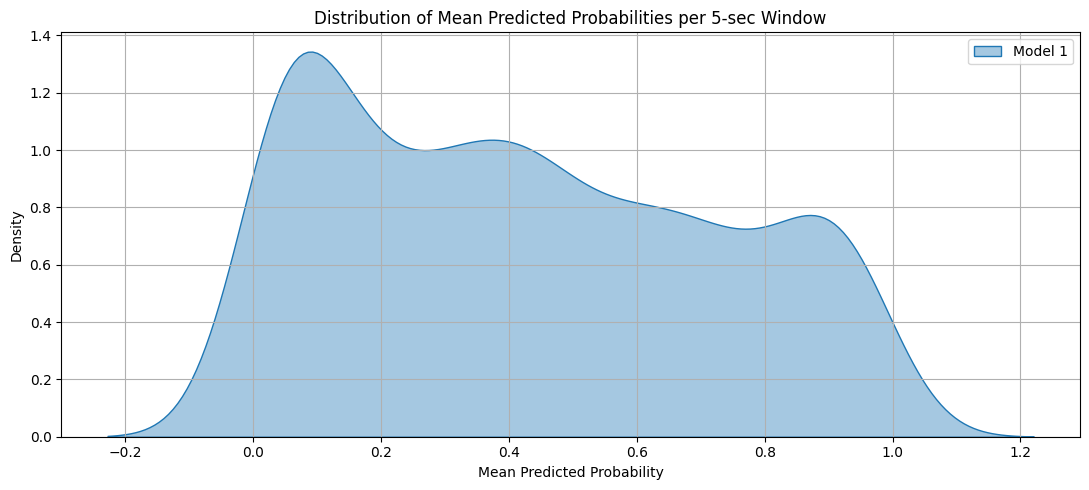

==== Summary Statistics per Model ====


,Model,Mean,Std,Min,Max
0,Model 1,0.42579,0.299385,0.005328,0.987828


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualize_model_prediction_distributions(inference_dfs, model_names=None):
    """
    複数モデルのinference出力を可視化する。row_idを除いて平均確率を使う。
    Args:
        inference_dfs (List[pd.DataFrame]): モデルごとの予測データフレーム（row_id含む）
        model_names (List[str], optional): モデル名リスト。未指定なら自動で"Model 1"などに。
    """
    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(len(inference_dfs))]

    plt.figure(figsize=(11, 5))
    stats = []

    for df, name in zip(inference_dfs, model_names):
        # row_id を除いた予測部分だけ抽出
        preds_only = df.drop(columns=["row_id"])
        mean_probs = preds_only.max(axis=1)

        # 分布（KDEプロット）
        sns.kdeplot(mean_probs, label=name, fill=True, alpha=0.4)

        # 統計情報の記録
        stats.append({
            "Model": name,
            "Mean": mean_probs.mean(),
            "Std": mean_probs.std(),
            "Min": mean_probs.min(),
            "Max": mean_probs.max(),
        })

    plt.title("Distribution of Mean Predicted Probabilities per 5-sec Window")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 統計情報の表示
    stats_df = pd.DataFrame(stats)
    print("==== Summary Statistics per Model ====")
    display(stats_df)
    
visualize_model_prediction_distributions([submission_df])